In [1]:
import os
os.environ["WANDB_MODE"] = "offline"

In [2]:
import importlib
import segment
importlib.reload(segment)
from segment import load_report_with_images, get_docs_with_ocr
from doctr.models import ocr_predictor
import os
import pickle

CACHE_PATH = "../data/cache/ocr_docs3.pkl"

if os.path.exists(CACHE_PATH):
    print("Loading docs from cache...")
    with open(CACHE_PATH, "rb") as f:
        docs = pickle.load(f)
    print("Loaded from cache:", len(docs))
else:
    ocr_model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True).cuda()
    items = load_report_with_images(limit=32)
    print("Loaded:", len(items))
    docs = get_docs_with_ocr(items, ocr_model)
    os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    with open(CACHE_PATH, "wb") as f:
        pickle.dump(docs, f)
    print("Saved docs to cache:", CACHE_PATH)

docs = [doc for doc in docs if len(doc['segments']) < 120]
print("Processed Docs:", len(docs))

Loading docs from cache...
Loaded from cache: 995
Processed Docs: 995


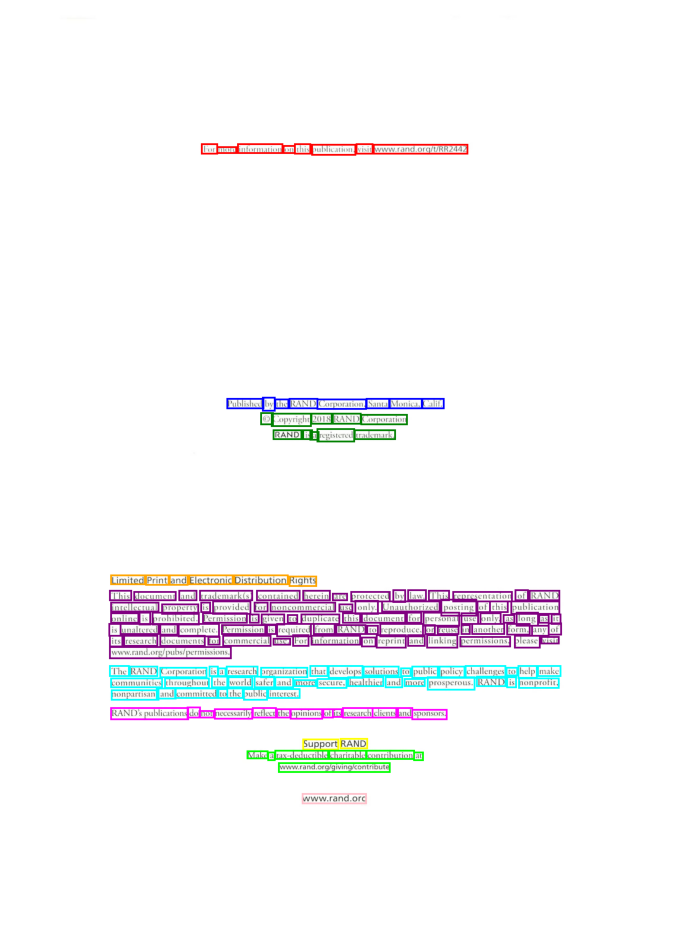

In [3]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import importlib
import visualize
importlib.reload(visualize)
import segment
importlib.reload(segment)
from segment import load_report_with_images, get_docs_with_ocr
from visualize import visualize_word_boxes

# docs = get_docs_with_ocr(items[:2], ocr_model)
data = docs[1]
img = visualize_word_boxes(data["image_path"], data["boxes"], data["labels"])
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
from datasets import Dataset
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from PIL import Image, ImageDraw, ImageFont
import torch
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from torch.utils.data import DataLoader


processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

# we need to define custom features
# features = Features({
#     'image': Array3D(dtype="int64", shape=(3, 224, 224)),
#     'input_ids': Sequence(feature=Value(dtype='int64')),
#     'attention_mask': Sequence(Value(dtype='int64')),
#     'token_type_ids': Sequence(Value(dtype='int64')),
#     'bbox': Array2D(dtype="int64", shape=(512, 4)),
#     'labels': Sequence(ClassLabel(names=labels)),
# })

def normalize_doc(d):
    h, w = d['dimensions']
    for box in d['boxes']:
        box[0] = int(box[0] / w * 1000)
        box[1] = int(box[1] / h * 1000)
        box[2] = int(box[2] / w * 1000)
        box[3] = int(box[3] / h * 1000)
    return {
        "words": d["words"],          # list of strings
        "boxes": d["boxes"],
        "labels": d["labels"],        # list of ints
        "image_path": d["image_path"]
    }


def preprocess_data(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  words = examples['words']
  boxes = examples['boxes']
  word_labels = examples['labels']
  
  encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                             padding="max_length", truncation=True)
  
  return encoded_inputs

rows = [normalize_doc(d) for d in docs]
ds = Dataset.from_list(rows)
ds = ds.train_test_split(test_size=0.1, seed=42)
train_dataset = ds['train'].map(preprocess_data, batched=True, remove_columns=ds['train'].column_names)
test_dataset = ds['test'].map(preprocess_data, batched=True, remove_columns=ds['test'].column_names)

train_dataset.set_format(type="torch")
test_dataset.set_format(type="torch")

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

Map:   0%|          | 0/895 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [5]:
from transformers import LayoutLMv3ForTokenClassification

device = 'cuda'
# load the fine-tuned model from the hub
model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base', num_labels=128)
model = model.to(device)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import evaluate
metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

Using the latest cached version of the module from /home/compiling-ganesh/24m0797/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--accuracy/f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Tue Nov 25 11:30:05 2025) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/compiling-ganesh/24m0797/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--f1/34c46321f42186df33a6260966e34a368f14868d9cc2ba47d142112e2800d233 (last modified on Tue Nov 25 11:27:07 2025) since it couldn't be found locally at evaluate-metric--f1, or remotely on the Hugging Face Hub.


In [7]:
import numpy as np

# Metrics
return_entity_level_metrics = True

id2label = [str(n) for n in np.arange(128)]
label2id = {label: idx for idx, label in enumerate(id2label)}

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    
    # Flatten but remove -100
    true_preds = []
    true_labels = []
    
    for pred_row, label_row in zip(preds, labels):
        for p_i, l_i in zip(pred_row, label_row):
            if l_i != -100:       # keep only real tokens
                true_preds.append(int(p_i))
                true_labels.append(int(l_i))

    return {
        "accuracy": metric_acc.compute(predictions=true_preds, references=true_labels)['accuracy'],
        "f1_macro": metric_f1.compute(predictions=true_preds, references=true_labels, average="macro")['f1']
    }


In [12]:
from transformers import TrainingArguments, Trainer
import wandb

class LayoutTrainer(Trainer):
    def get_train_dataloader(self):
      return train_dataloader

    def get_test_dataloader(self, test_dataset):
      return test_dataloader

args = TrainingArguments(
    output_dir="../models/layoutlmv3-finetuned", # name of directory to store the checkpoints
    max_steps=3000, # we train for a maximum of 1,000 batches
    warmup_ratio=0.1, # we warmup a bit
    fp16=True, # we use mixed precision (less memory consumption)
    push_to_hub=False, # after training, we'd like to push our model to the hub
    report_to=["wandb"],          
    run_name="layoutlmv3-run-1",  
    logging_steps=1,  
    eval_strategy="steps",
    eval_steps=50,
)

# Initialize our Trainer
trainer = LayoutTrainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,   
    eval_dataset=test_dataset
)

trainer.train()

/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
50,4.417400,3.152809,0.126830,0.010023
100,2.241500,3.075505,0.136889,0.014867
150,2.855700,3.011275,0.142008,0.013930
200,2.214200,2.973054,0.152855,0.016226
250,2.735600,2.819552,0.160086,0.021806
300,3.070100,2.854511,0.165885,0.018977
350,2.143700,2.963625,0.135744,0.019342
400,4.942200,2.768928,0.162019,0.023584
450,3.044100,2.576390,0.207517,0.032048
500,1.930600,2.538621,0.238411,0.035338


/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warni

TrainOutput(global_step=3000, training_loss=1.8441621386731664, metrics={'train_runtime': 816.9122, 'train_samples_per_second': 117.516, 'train_steps_per_second': 3.672, 'total_flos': 3185011689259008.0, 'train_loss': 1.8441621386731664, 'epoch': 13.392857142857142})

In [10]:
predictions, labels, metrics = trainer.predict(test_dataset)
print(metrics)

/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test_loss': 3.263634443283081, 'test_accuracy': 0.107213173438339, 'test_f1_macro': 0.007869773746572861, 'test_runtime': 4.2721, 'test_samples_per_second': 23.407, 'test_steps_per_second': 0.936}


In [ ]:
import numpy as np

flat = np.concatenate([np.array(r) for r in train_dataset["labels"]])
unique, counts = np.unique(flat, return_counts=True)

for u, c in zip(unique, counts):
    print(f"{u}: {c}")

In [13]:
def preprocess_data(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    words = examples["words"]
    boxes = examples["boxes"]
    decoder_labels = examples["labels"]  # word-level labels

    enc = processor(
        images,
        words,
        boxes=boxes,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # we store decoder labels separately
    enc["decoder_labels"] = decoder_labels

    return enc

preprocess_data(docs)

TypeError: list indices must be integers or slices, not str